# Label refinement for detection of disease-relevant populations in case-control single-cell data with HiDDEN

**Author**: Aleksandrina Goeva \
**Date**: 16/08/2023

In this notebook I go over how to run HiDDEN to refine the coarse binary sample-level labels into cell-specific continuous perturbation scores and refined binary labels in a case / control single cell experiment to reveal potentially hidden heterogeneity undetected with the standard analysis workflow. Running through this tutorial takes approximately 10 minutes.

## Setup imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
root_path = os.path.abspath('./..')
sys.path.insert(0, root_path )

import itertools
import functools
from tqdm import tqdm

import pandas as pd
import numpy as np
import sklearn
import sklearn.linear_model
import sklearn.cluster
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns

import hiddensc
from hiddensc import utils, files, vis

import scanpy as sc
import scvi
import anndata

utils.set_random_seed(utils.RANDOM_SEED)
utils.print_module_versions([sc, anndata, scvi, hiddensc])
vis.visual_settings()

Global seed set to 0


Random seed set to 42
scanpy              : 1.9.3
anndata             : 0.8.0
scvi                : 0.20.3
hiddensc            : beta_24.07.23


In [3]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.simplefilter("ignore", category=ConvergenceWarning)

## Load and prepare the example dataset

In this tutorial we will work with a semi-simulated case / control single-cell dataset of single-cell RNAseq profiles of Naive B and Memory B cells from a dataset of PBMCs freely available from 10x Genomics. The control sample consists of real transcriptional profiles of Naive B cells and the case sample consists of 15% Memory B and 85% Naive B cells. \
We use this dataset as an example for how to identify the presence of 'Control'-like cells in the 'Case' sample and separate out the subpopulation of truly perturbed cells. For more details on this dataset generation, refer to Figure 2 and the Methods section of the manuscript.

In [4]:
PREFIX = f'naiveB_1900_memoryB_154'
at_data_dir = functools.partial(os.path.join, root_path, files.DATA_DIR)
adata = sc.read(at_data_dir(f'{PREFIX}_raw.h5ad'))
adata.obs['binary_label'] = adata.obs['batch']=='Case'
hiddensc.datasets.preprocess_data(adata)
hiddensc.datasets.normalize_and_log(adata)
adata

AnnData object with n_obs × n_vars = 2054 × 14603
    obs: 'barcodes', 'batch', 'perturbed', 'binary_label', 'n_genes'
    var: 'gene_ids', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [5]:
# Prepare directories
at_figure_dir = functools.partial(os.path.join, root_path, 'figures', 'tutorial')
os.makedirs(at_figure_dir(), exist_ok=True)
at_results_dir = functools.partial(os.path.join, root_path, files.RESULT_DIR, 'tutorial')
os.makedirs(at_results_dir(), exist_ok=True)
at_train_dir = functools.partial(os.path.join, root_path, files.RESULT_DIR, 'tutorial', 'training')
os.makedirs(at_train_dir(), exist_ok=True)

print(f'Generating results at {at_results_dir()}')

Generating results at /home/jupyter/LabelCorrection/results/tutorial


In [27]:
hiddensc.datasets.augment_for_analysis(adata)

/opt/conda/envs/hidden/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


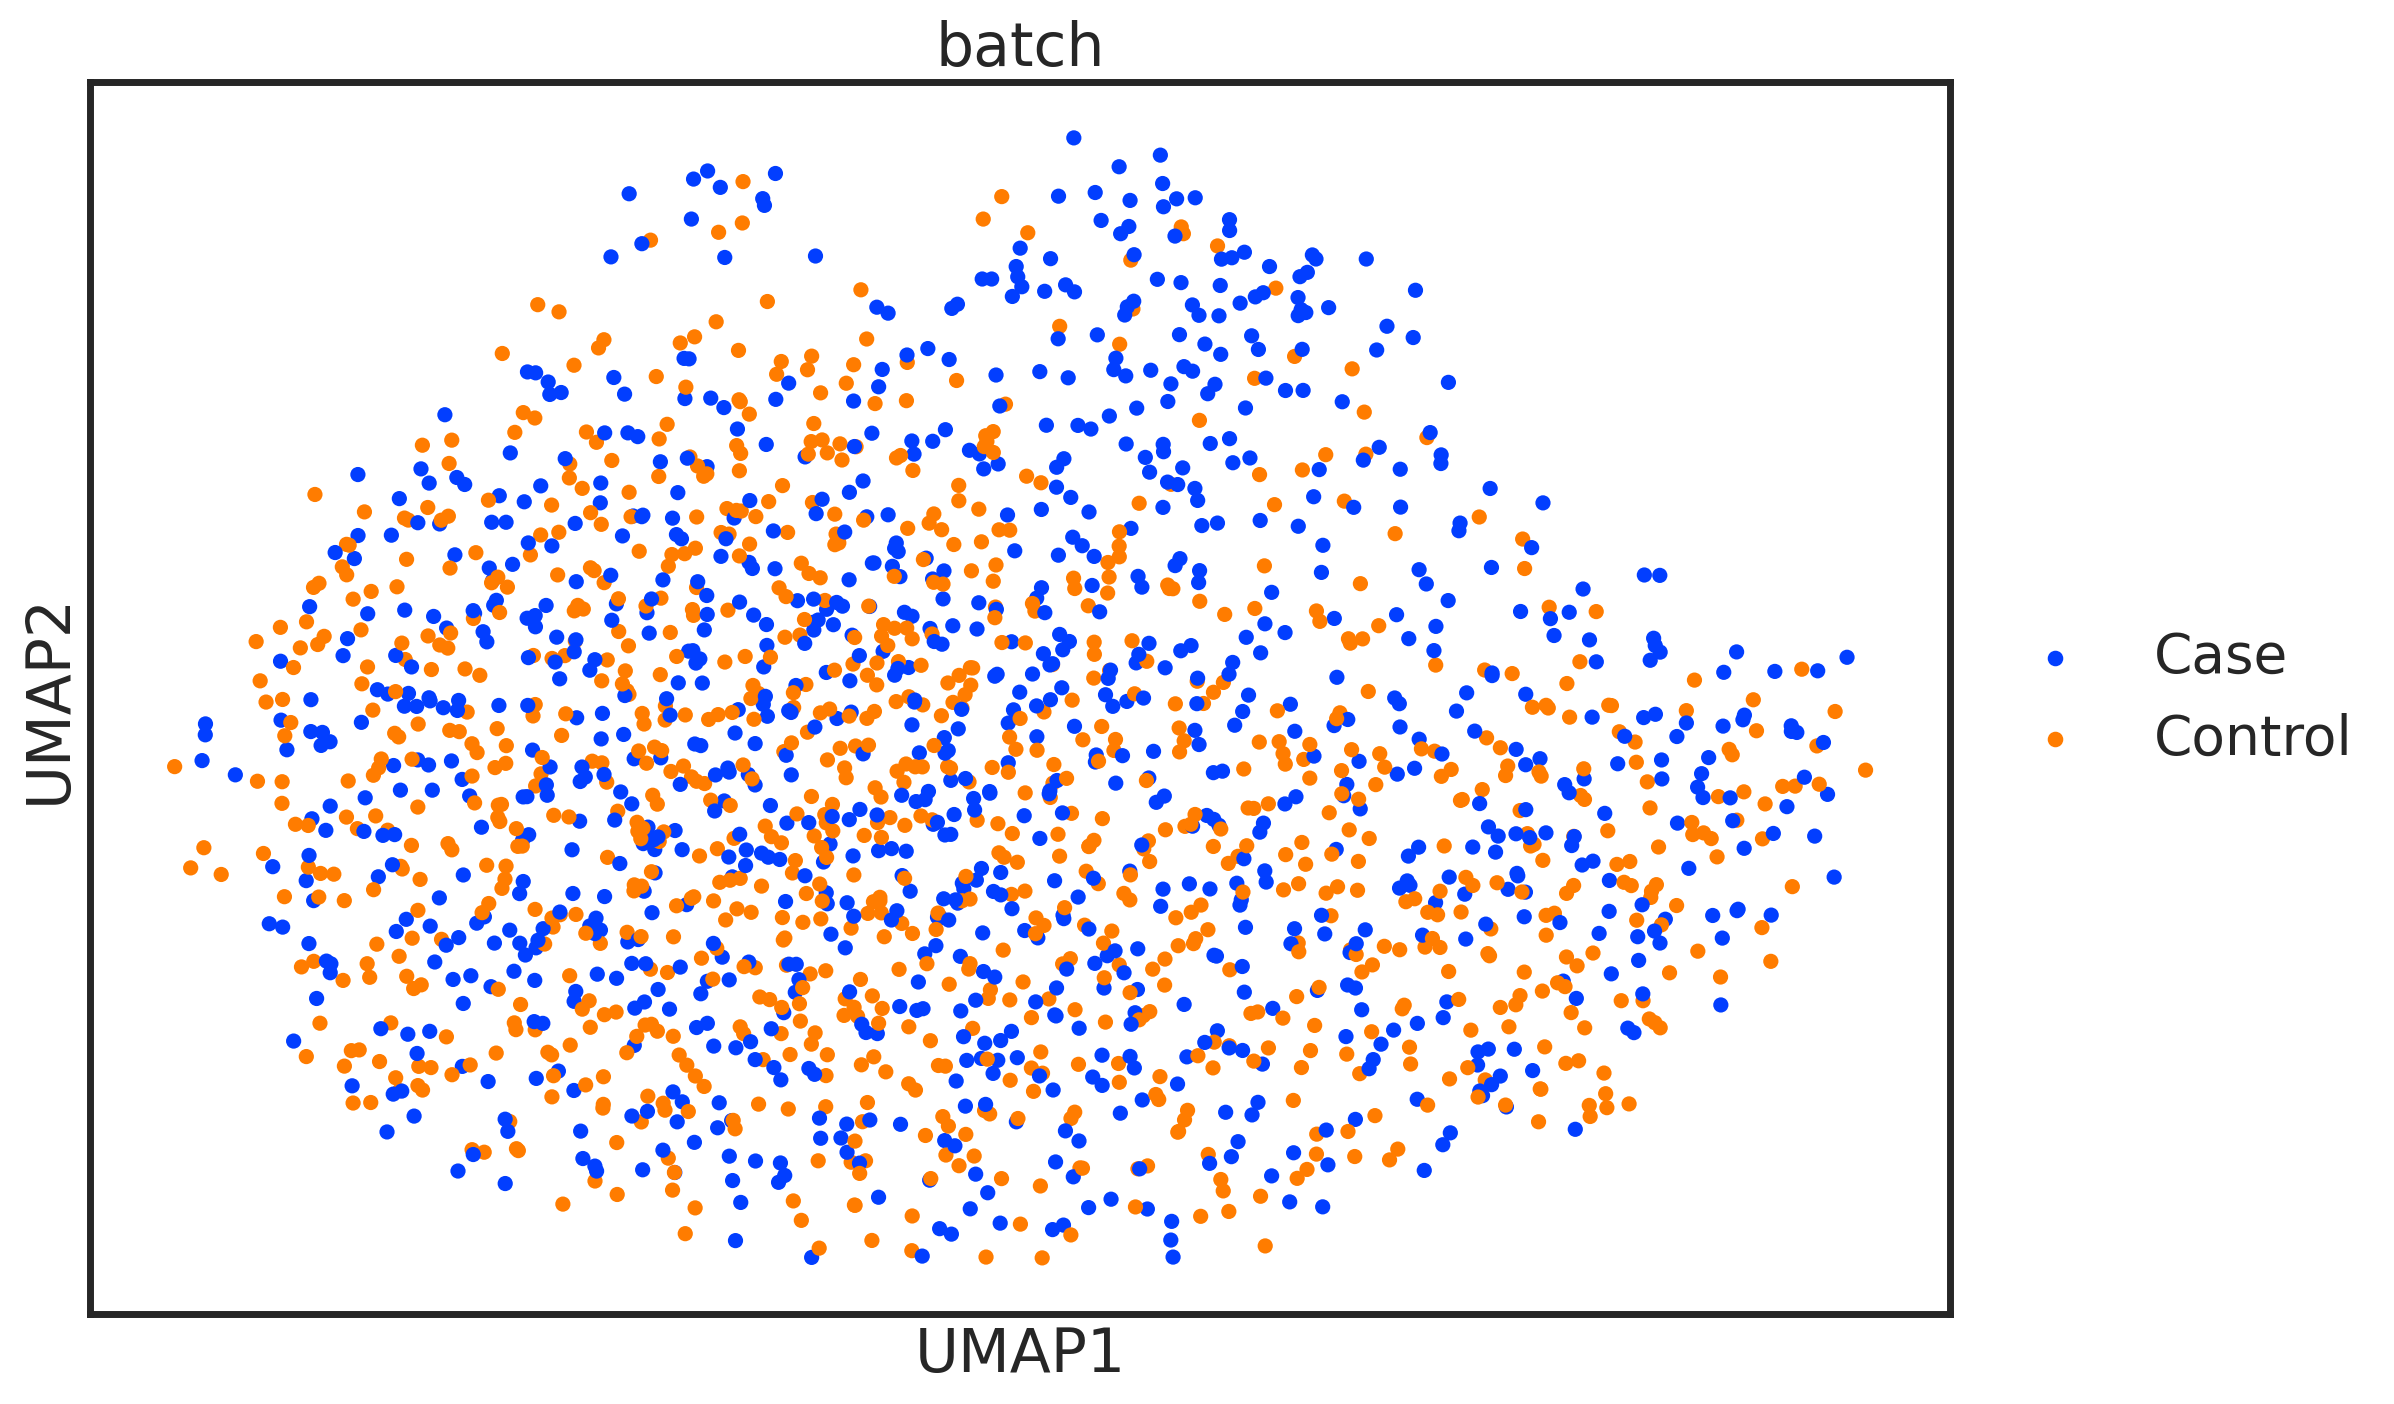

In [28]:
sc.pl.umap(adata, color=['batch'], s=120)

There are no noticeable clusters enriched in either 'Case' nor 'Control' identities. Additional quantitative metrics of the inability of the standard analysis workflow to identify the Memory B subpopulation are included in the manuscript.

# HiDDEN analysis

The first step of the HiDDEN framework is to compute a dimensionality-reduced representation of the single-cell data. Here you can either load a representation you have already computed, such as one post-removal of batch effects or other confounders. The *hiddensc* framework offers you a selection of dimensionality reduction approaches to explore, including PCA and scvi (Gayoso et al. Nature biotechnology, 2022).

There is a single tunning parameter in this approach -- the number of latent dimensions. We provide two heuristics for chosing the optimal value of this parameter, as well as demonstrate that the framework performs well for a wide range of values. Consult the Methods section of the manuscript for more details.

## Compute optimal number of principal components

In [6]:
num_pcs, ks, ks_pval = hiddensc.models.determine_pcs_heuristic_ks(adata=adata, orig_label="binary_label", max_pcs=60)

  0%|          | 0/59 [00:00<?, ?it/s]

In [7]:
optimal_num_pcs_ks = num_pcs[np.argmax(ks)]

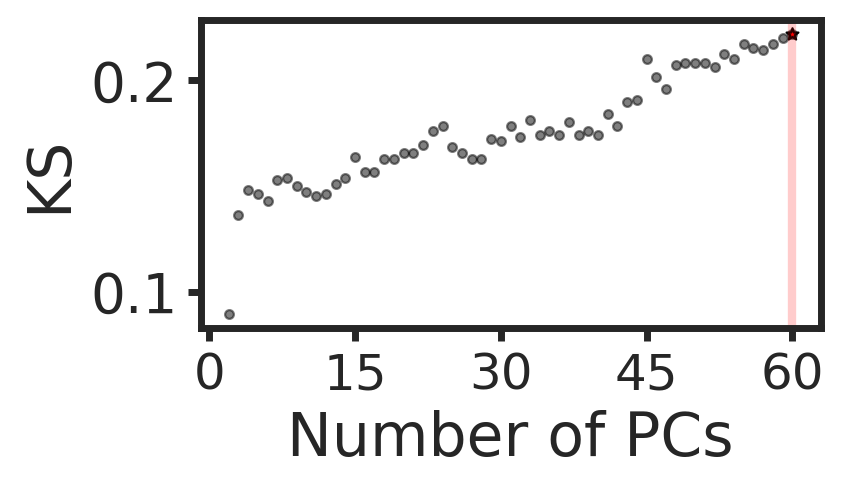

In [8]:
plt.figure(figsize=(4, 2))
plt.scatter(num_pcs, ks, s=10, c='k', alpha=0.5)
plt.axvline(x = optimal_num_pcs_ks, color = 'r', alpha=0.2)
plt.scatter(optimal_num_pcs_ks, ks[np.argmax(ks)], s=20, c='r', marker='*', edgecolors='k')
plt.xticks(np.append(np.arange(0, 60, 15), optimal_num_pcs_ks), fontsize=18)
plt.xlabel('Number of PCs')
plt.ylabel('KS')
plt.show()

# Generate dim reduced features

In [9]:
feats = {}

### PCA

In [10]:
x_pca = hiddensc.models.get_pca(adata, n_comps=optimal_num_pcs_ks)
feats['PCA'] = x_pca

### SCVI / LinearSCVI

  0%|          | 0/2 [00:00<?, ?it/s]No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|██████████| 250/250 [00:50<00:00,  5.01it/s, loss=2.24e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [00:50<00:00,  5.00it/s, loss=2.24e+03, v_num=1]


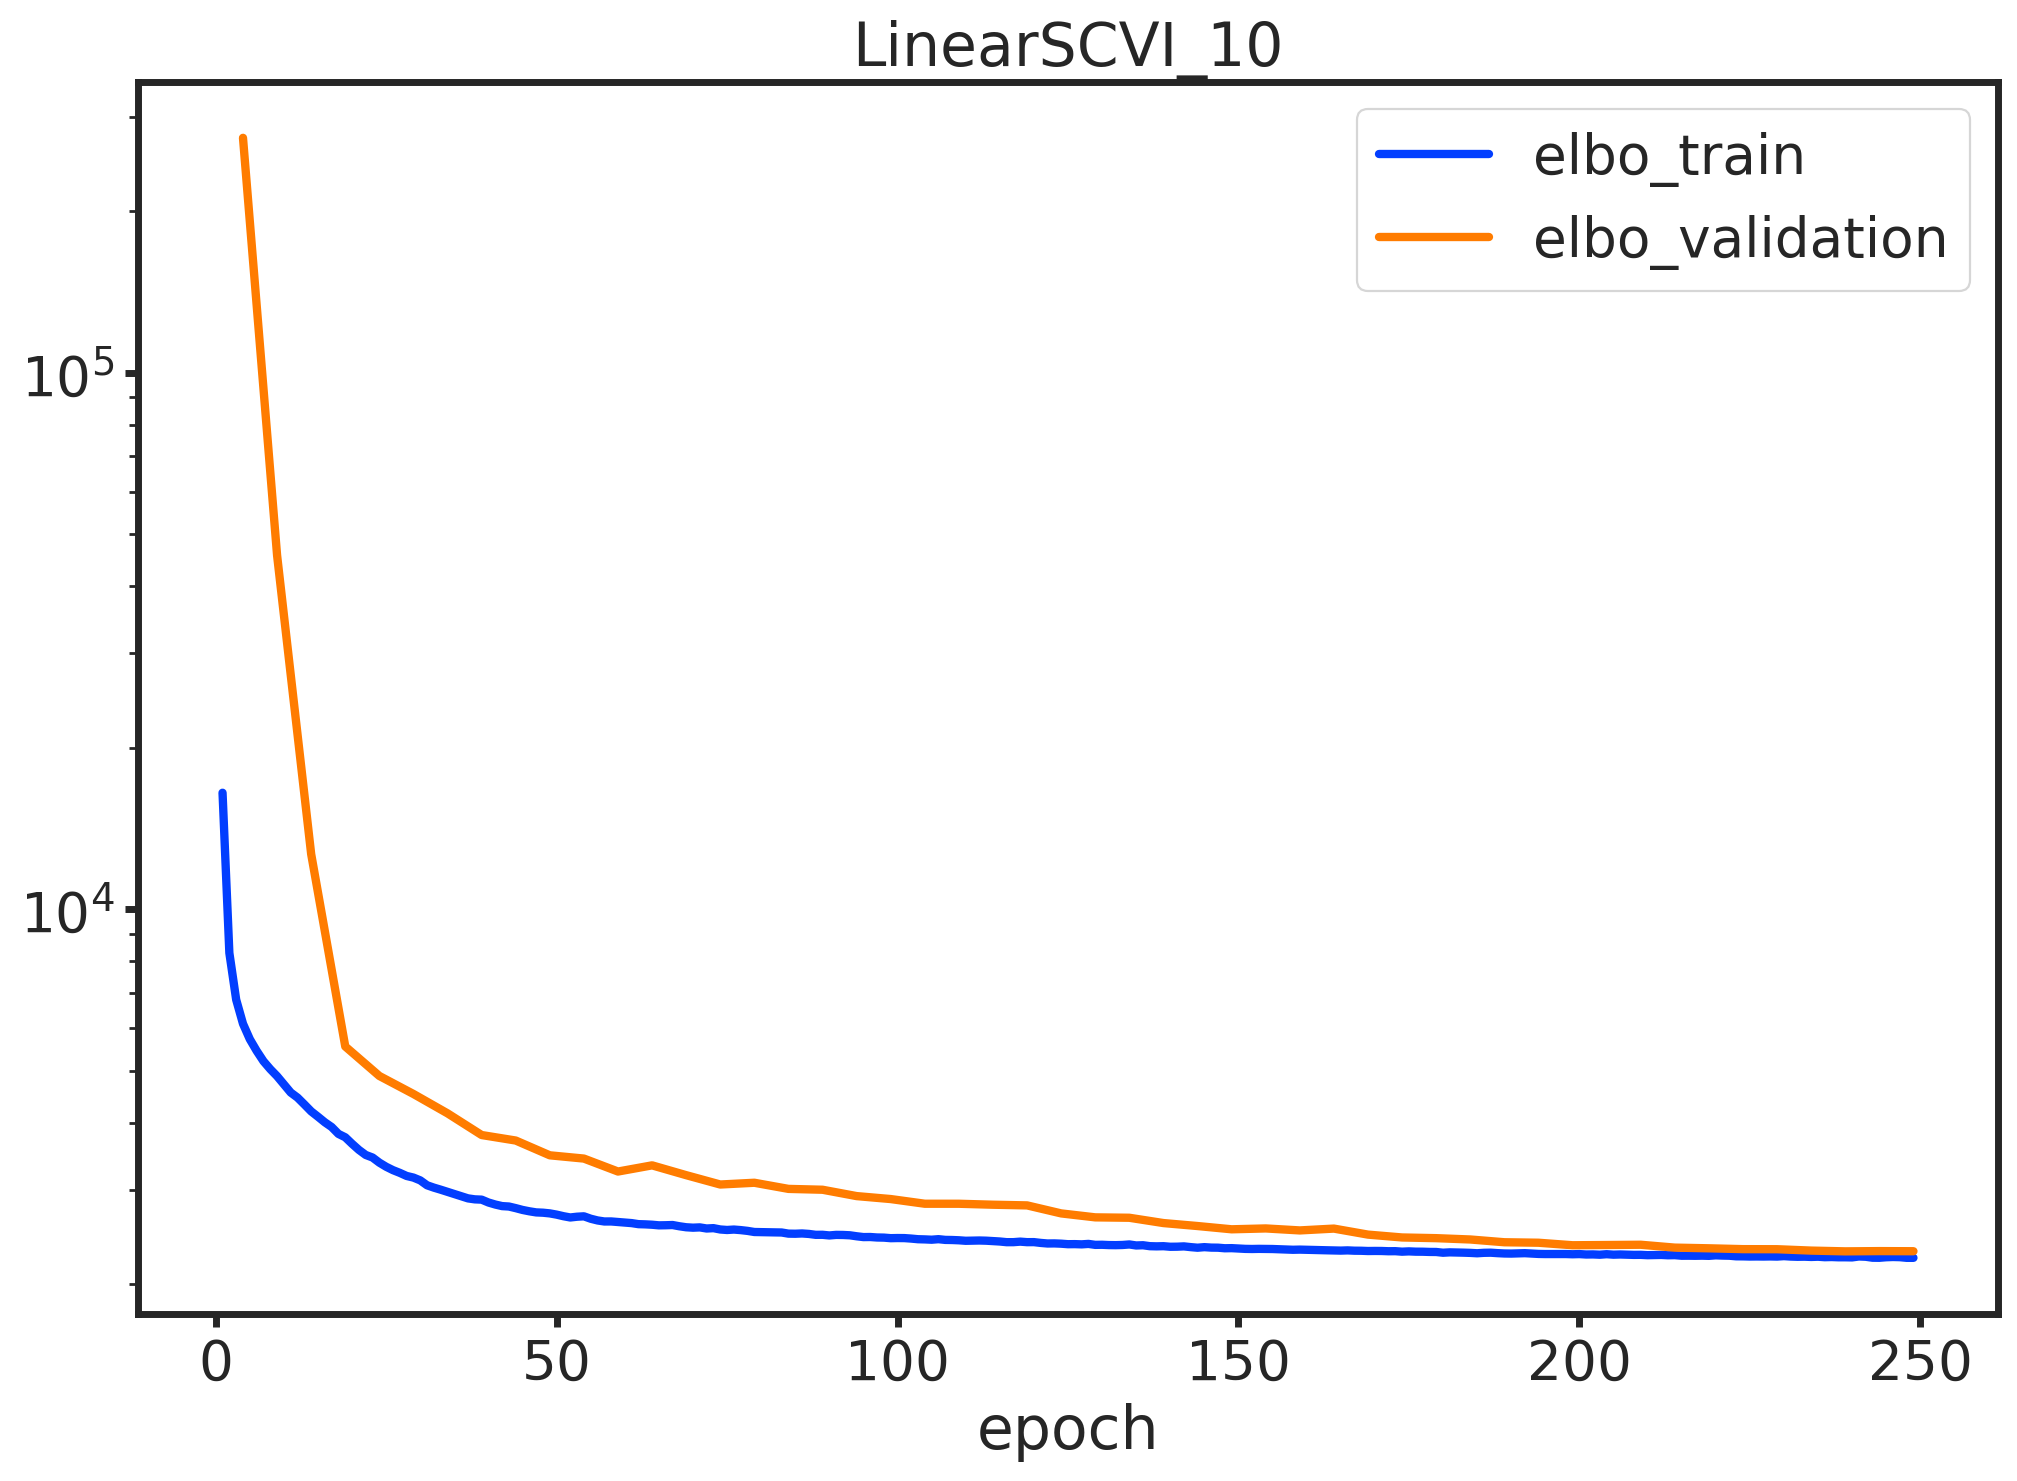

 50%|█████     | 1/2 [00:53<00:53, 53.00s/it]GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 250/250: 100%|██████████| 250/250 [00:51<00:00,  4.75it/s, loss=1.9e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [00:51<00:00,  4.86it/s, loss=1.9e+03, v_num=1]


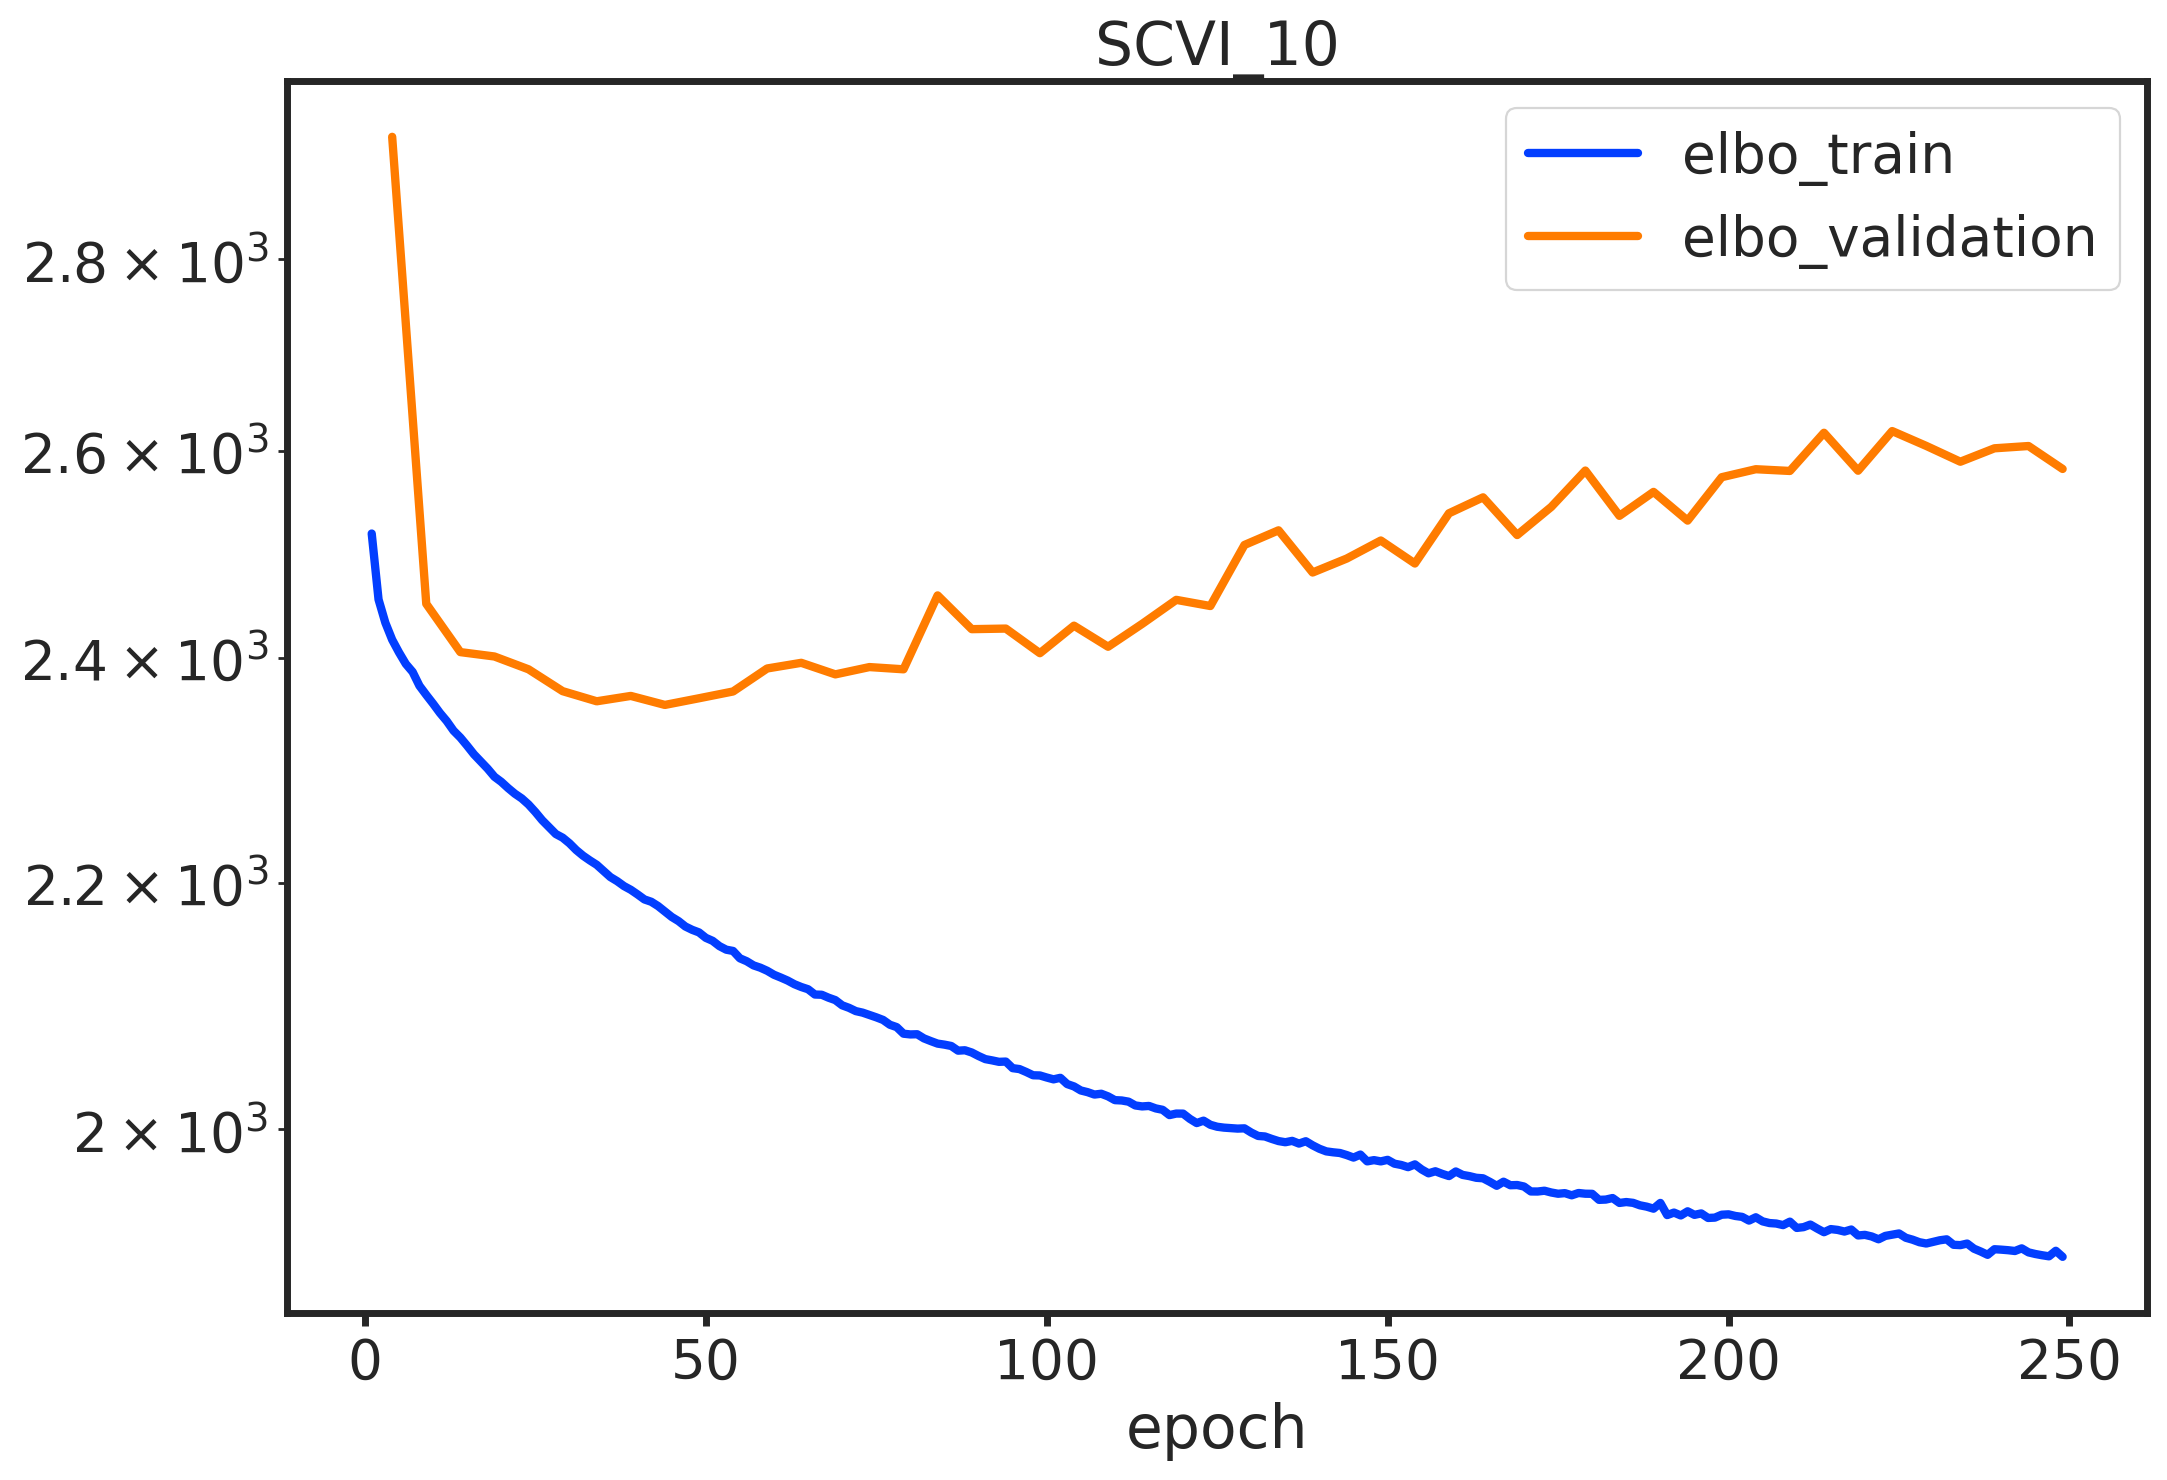

100%|██████████| 2/2 [01:45<00:00, 52.71s/it]


In [11]:
n_epochs = 250

model_classes = [scvi.model.LinearSCVI, scvi.model.SCVI]
ks = [10]#, 20, 30, 40, 50]
combos = list(itertools.product(model_classes, ks))

for model_cls, k in tqdm(combos):
    local_adata = adata.copy()
    name = f'{model_cls.__name__}_{k}'
    model_cls.setup_anndata(local_adata, layer="counts")
    model = model_cls(local_adata, n_latent=k)
    model.train(max_epochs=n_epochs, plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=5)
    train_elbo = model.history["elbo_train"][1:]
    test_elbo = model.history["elbo_validation"]
    ax = train_elbo.plot()
    test_elbo.plot(ax=ax)
    plt.yscale('log')
    #plt.savefig(at_train_dir(f'{name}.png'))
    plt.title(name)
    feats[name] = model.get_latent_representation()
    plt.show()
    del local_adata

In [12]:
fname = at_results_dir('features.npz')
np.savez_compressed(fname, **feats)

## Generate predictions

The second component of the HiDDEN framework is a prediction model trained on the dimensionality-reduced features and the sample-level labels. The predictions from this model constitute the per-cell continuous perturbation scores, allowing us to explore a potential gradient effect of the perturbation or to cluster and produce refined binary labels.

In [13]:
feats = files.load_npz(at_results_dir('features.npz'))
y = (adata.obs['batch'].values == 'Case').astype(np.int32)
#y_true = (adata.obs['perturbed'].values == 'Memory B').astype(np.int32)
ids = adata.obs['barcodes'].values
pred_fns = {'logistic': hiddensc.models.logistic_predictions,
              'svm': hiddensc.models.svm_predictions}

preds = [y]#, y_true]
info = [('batch', '','Case')]#, ('perturbed', '','Memory B')]
combos = list(itertools.product(feats.keys(), pred_fns.keys()))

for feat_name, strat_name  in tqdm(combos):
    rand_state=0
    x = feats[feat_name]
    p_hat, p_labels = pred_fns[strat_name](x, y, 1, rand_state)
    preds.append(p_hat)
    info.append((feat_name, strat_name, 'p_hat'))
    preds.append(p_labels)
    info.append((feat_name, strat_name, 'p_label'))
    
cols = pd.MultiIndex.from_tuples(info)
pred_df = pd.DataFrame(np.array(preds).T, index=adata.obs['barcodes'], columns=cols)
pred_df.to_csv(at_results_dir('predictions.csv'))
pred_df

100%|██████████| 6/6 [00:30<00:00,  5.07s/it]


batch      PCA                        \
                                   logistic           svm           
                              Case    p_hat p_label p_hat p_label   
barcodes                                                            
naiveB_a_AAACCTGCACGGTAGA-1  1.000    0.543   0.000 0.546   1.000   
naiveB_a_AAACCTGCAGATGGGT-1  1.000    0.438   0.000 0.458   0.000   
naiveB_a_AAAGATGCATTTCAGG-1  0.000    0.302   0.000 0.439   0.000   
naiveB_a_AAAGCAAAGCCAACAG-1  0.000    0.393   0.000 0.449   0.000   
naiveB_a_AAAGCAAAGTGCCATT-1  1.000    0.531   0.000 0.500   0.000   
...                            ...      ...     ...   ...     ...   
memoryB_b_TGACTTTGTCACTTCC-1 1.000    0.629   1.000 0.545   1.000   
memoryB_b_TGTATTCGTTTGCATG-1 1.000    0.821   1.000 0.617   1.000   
memoryB_b_TGTATTCTCCTTTCTC-1 1.000    0.404   0.000 0.477   0.000   
memoryB_b_TTCTCCTCAGTCGATT-1 1.000    0.597   1.000 0.532   0.000   
memoryB_b_TTCTTAGTCGGCGCAT-1 1.000    0.762   1.000 0.587   1.000   

                             LinearSCVI_10                        SCVI_10  \
                                  logistic           svm         logistic   
                                     p_hat p_label p_hat p_label    p_hat   
barcodes                                                                    
naiveB_a_AAACCTGCACGGTAGA-1          0.437   0.000 0.461   0.000    0.375   
naiveB_a_AAACCTGCAGATGGGT-1          0.433   0.000 0.447   0.000    0.396   
naiveB_a_AAAGATGCATTTCAGG-1          0.359   0.000 0.409   0.000    0.370   
naiveB_a_AAAGCAAAGCCAACAG-1          0.407   0.000 0.430   0.000    0.469   
naiveB_a_AAAGCAAAGTGCCATT-1          0.562   0.000 0.535   0.000    0.418   
...                                    ...     ...   ...     ...      ...   
memoryB_b_TGACTTTGTCACTTCC-1         0.563   0.000 0.545   0.000    0.548   
memoryB_b_TGTATTCGTTTGCATG-1         0.815   1.000 0.780   1.000    0.648   
memoryB_b_TGTATTCTCCTTTCTC-1         0.696   1.000 0.671   1.000    0.672   
memoryB_b_TTCTCCTCAGTCGATT-1         0.563   0.000 0.565   0.000    0.614   
memoryB_b_TTCTTAGTCGGCGCAT-1         0.761   1.000 0.716   1.000    0.679   

                                                    
                                       svm          
                             p_label p_hat p_label  
barcodes                                            
naiveB_a_AAACCTGCACGGTAGA-1    0.000 0.401   0.000  
naiveB_a_AAACCTGCAGATGGGT-1    0.000 0.420   0.000  
naiveB_a_AAAGATGCATTTCAGG-1    0.000 0.409   0.000  
naiveB_a_AAAGCAAAGCCAACAG-1    0.000 0.481   0.000  
naiveB_a_AAAGCAAAGTGCCATT-1    0.000 0.441   0.000  
...                              ...   ...     ...  
memoryB_b_TGACTTTGTCACTTCC-1   1.000 0.534   1.000  
memoryB_b_TGTATTCGTTTGCATG-1   1.000 0.616   1.000  
memoryB_b_TGTATTCTCCTTTCTC-1   1.000 0.619   1.000  
memoryB_b_TTCTCCTCAGTCGATT-1   1.000 0.591   1.000  
memoryB_b_TTCTTAGTCGGCGCAT-1   1.000 0.625   1.000  

[2054 rows x 13 columns]

## Visualize predictions

### Choose amongst the options computed above:
* dimensionality reduction technique: e.g.'PCA', 'LinearSCVI_10', 'SCVI_10'
* prediction model: e.g. 'logistic', 'svm'

In [15]:
DIM_RED = 'PCA'
PRED_MODEL = 'logistic'

In [16]:
df = sc.get.obs_df(adata, ['batch', 'binary_label'])
df.columns = ['batch', 'binary_label']
df['p_hat'] = pred_df[f'{DIM_RED}'][f'{PRED_MODEL}']['p_hat'].values
df['new_label'] = pred_df[f'{DIM_RED}'][f'{PRED_MODEL}']['p_label'].values
df[' '] = 1

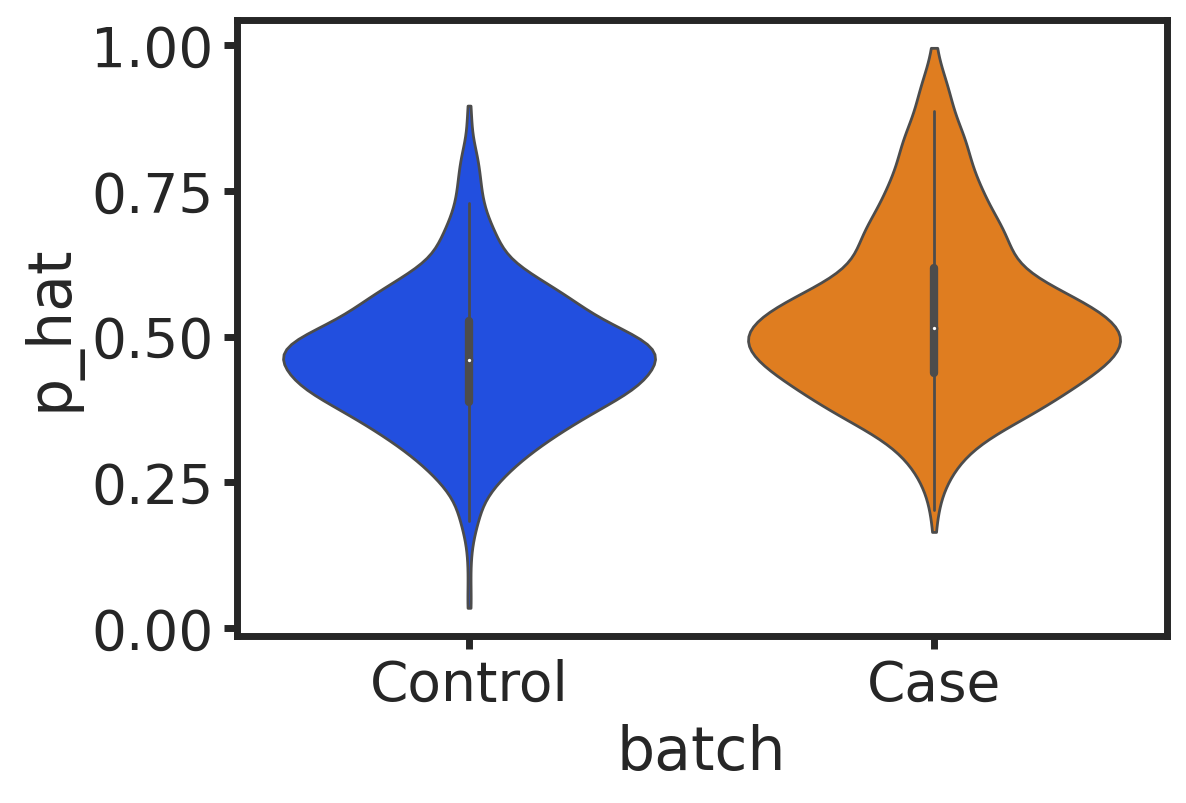

In [17]:
plt.figure(figsize=(6, 4))
sns.violinplot(data=df, x="batch", y="p_hat", linewidth=1, scale='count', cut=0, order=['Control', 'Case'])
plt.show()

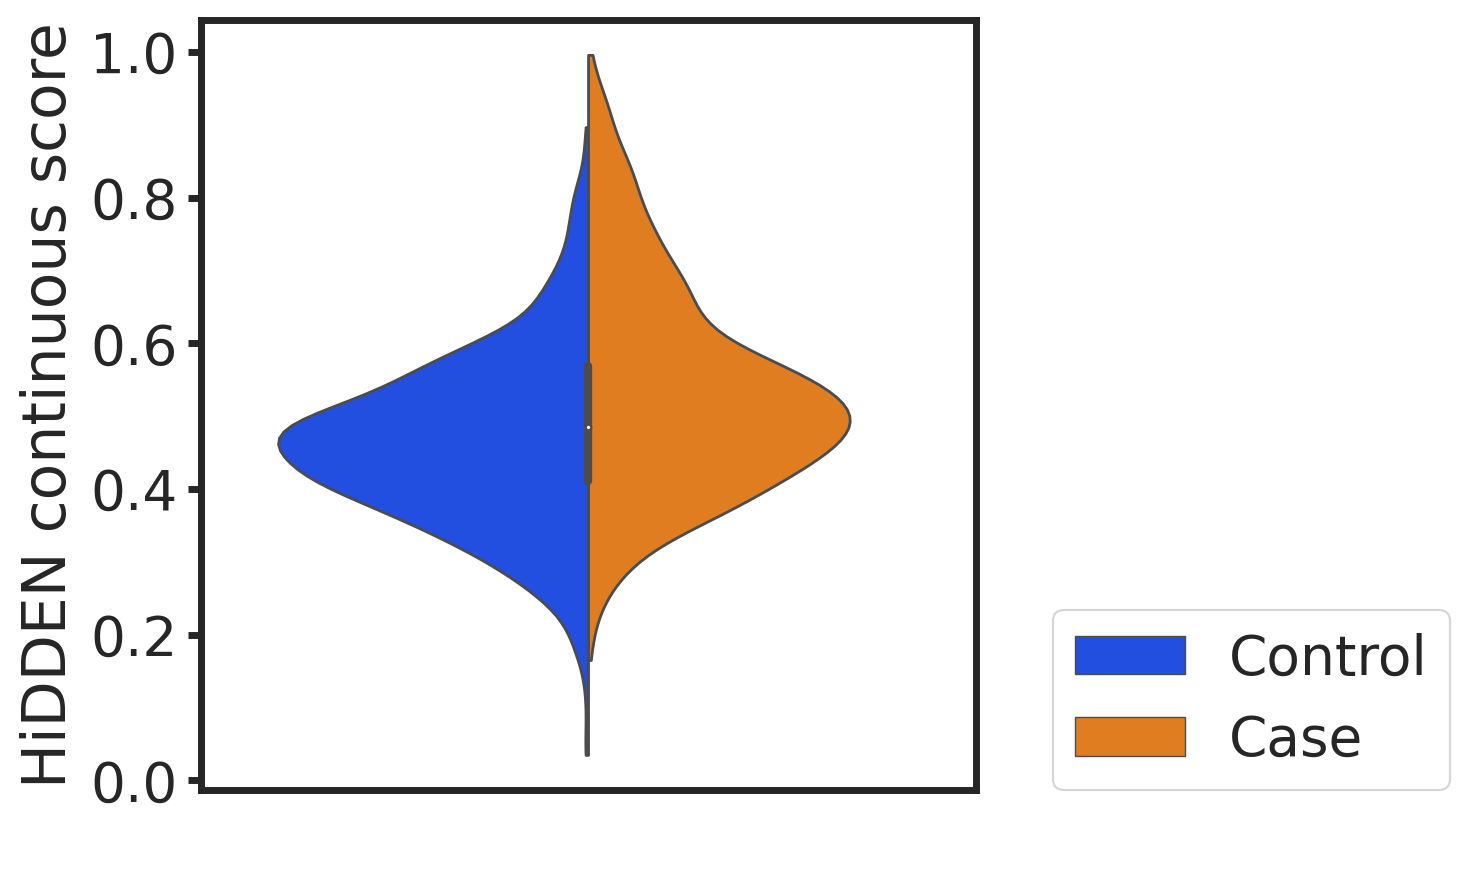

In [18]:
plt.figure(figsize=(5, 5))
sns.violinplot(data=df, x=" ", y="p_hat", hue="batch", linewidth=1, cut=0, split=True, hue_order=['Control', 'Case'])
plt.xticks([])
plt.ylabel('HiDDEN continuous score')
plt.legend(loc=[1.1, 0])
plt.show()

In [19]:
conditions = [
    (df['binary_label']==0),
    (df['binary_label']==1) & (df['new_label']==0),
    (df['binary_label']==1) & (df['new_label']==1)
]
values = ['Control_L0', 'Case_L0', 'Case_L1']
df['three_labels'] = np.select(conditions, values)

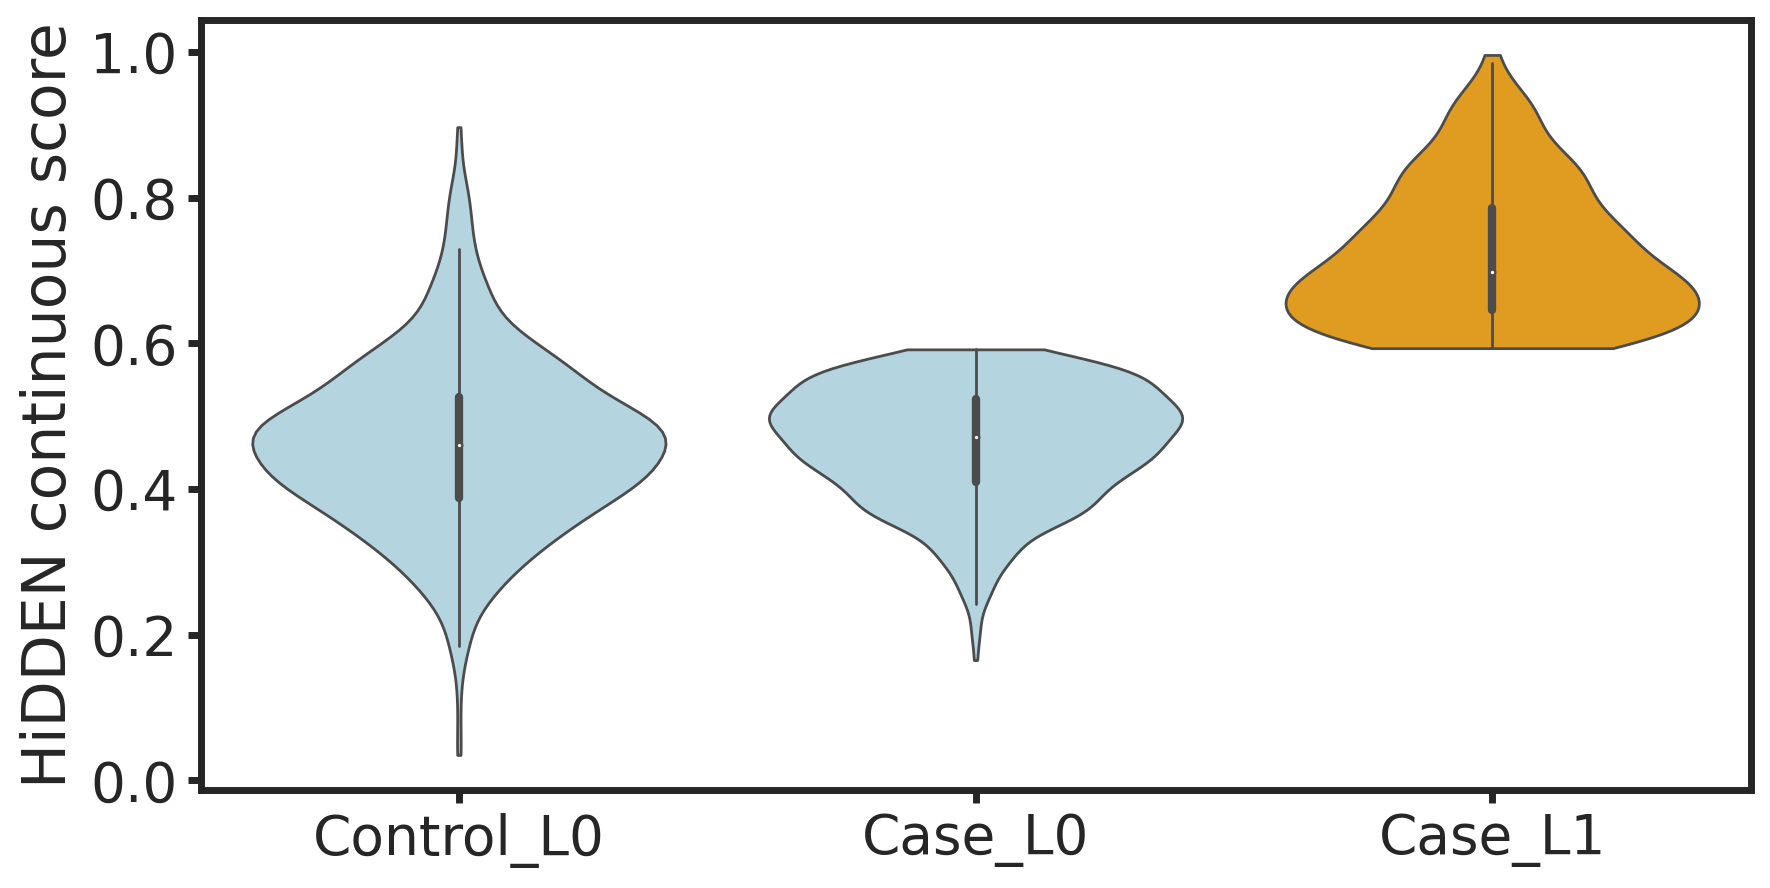

In [20]:
plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x="three_labels", y="p_hat", linewidth=1, scale='width', cut=0, order=['Control_L0', 'Case_L0', 'Case_L1'], 
               palette=['lightblue', 'lightblue', 'orange'])
plt.ylabel('HiDDEN continuous score')
plt.xlabel("")
plt.show()

In [21]:
np.sum(df['three_labels']=='Case_L1')

298

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


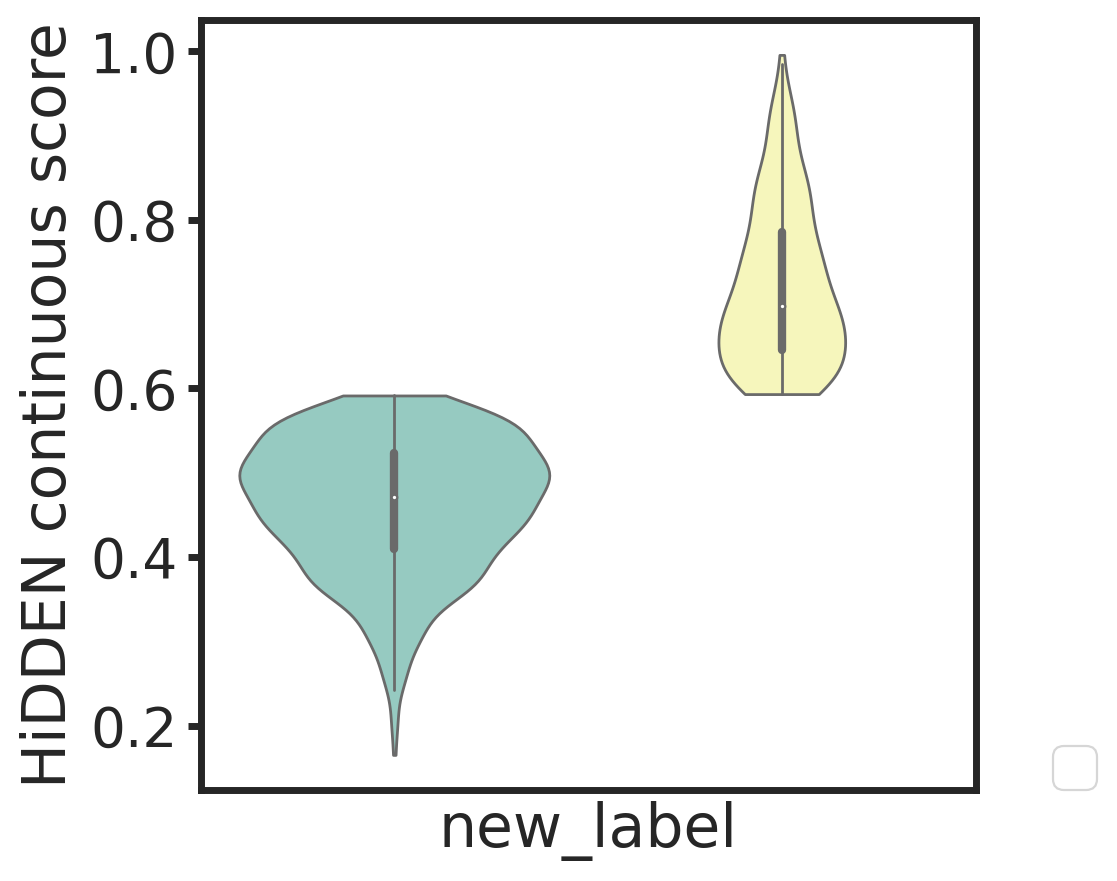

In [22]:
df_sub = df.copy()[df['binary_label']==1]
plt.figure(figsize=(5, 5))
sns.violinplot(data=df_sub, x="new_label", y="p_hat", linewidth=1, scale='count', cut=0, palette='Set3')
plt.xticks([])
plt.ylabel('HiDDEN continuous score')
plt.legend(loc=[1.1, 0])
plt.show()

# DE genes

In [23]:
adata.obs['new_label'] = pred_df[f'{DIM_RED}'][f'{PRED_MODEL}']['p_label'].values
de_genes = hiddensc.datasets.get_de_genes(adata, 'new_label')
de_genes.update(hiddensc.datasets.get_de_genes(adata, 'batch'))
de_genes

{'0.0': array(['IGHD', 'TCL1A', 'BTG1', 'CXCR4', 'CD74', 'MEF2C', 'RPL18A',
        'TMSB10', 'FCER2', 'HLA-DRA', 'MT-ND2', 'IGHM', 'HLA-DQB1',
        'HLA-DRB1', 'IL4R', 'PLPP5', 'CD79B', 'HLA-DRB5', 'CD37', 'MT-CYB',
        'RPS19', 'SERF2', 'MT-ATP6', 'LAPTM5', 'BIRC3', 'CD72', 'RPL21'],
       dtype='<U8'),
 '1.0': array(['B2M', 'COTL1', 'RPS18', 'HLA-B', 'EEF1A1', 'RP5-887A10.1',
        'RPS14', 'GAPDH', 'HLA-C', 'SLC25A6', 'JCHAIN', 'IGHA1', 'NEAT1',
        'S100A6', 'HSPA8', 'IGHG1', 'RPS15A', 'ITGB1', 'RPL14', 'TPT1',
        'RPS29', 'CLECL1', 'S100A4', 'RPS20', 'HLA-A', 'VIM', 'PTP4A2',
        'CD27', 'GPR183', 'RPS8', 'YWHAZ', 'EEF2', 'RPL27A', 'S100A10',
        'LY6E', 'RPLP1', 'TOMM7', 'MALAT1', 'CRIP1', 'PRKCB', 'ACTG1',
        'AL928768.3', 'RP5-1171I10.5', 'EVI2B'], dtype='<U13'),
 'Case': array([], dtype='<U1'),
 'Control': array([], dtype='<U1')}

In [24]:
print(de_genes['Control'].shape)
print(de_genes['Case'].shape)
print(de_genes['0.0'].shape)
print(de_genes['1.0'].shape)

(0,)
(0,)
(27,)
(44,)


DE testing with the original sample-level labels yields no DE genes and completely fails to identify the DE genes. Running DE with the HiDDEN-refined binary labels, however, identifies a number of Naive B and Memory B markers.

In [25]:
adata.obs['three_labels'] = df['three_labels']

/opt/conda/envs/hidden/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


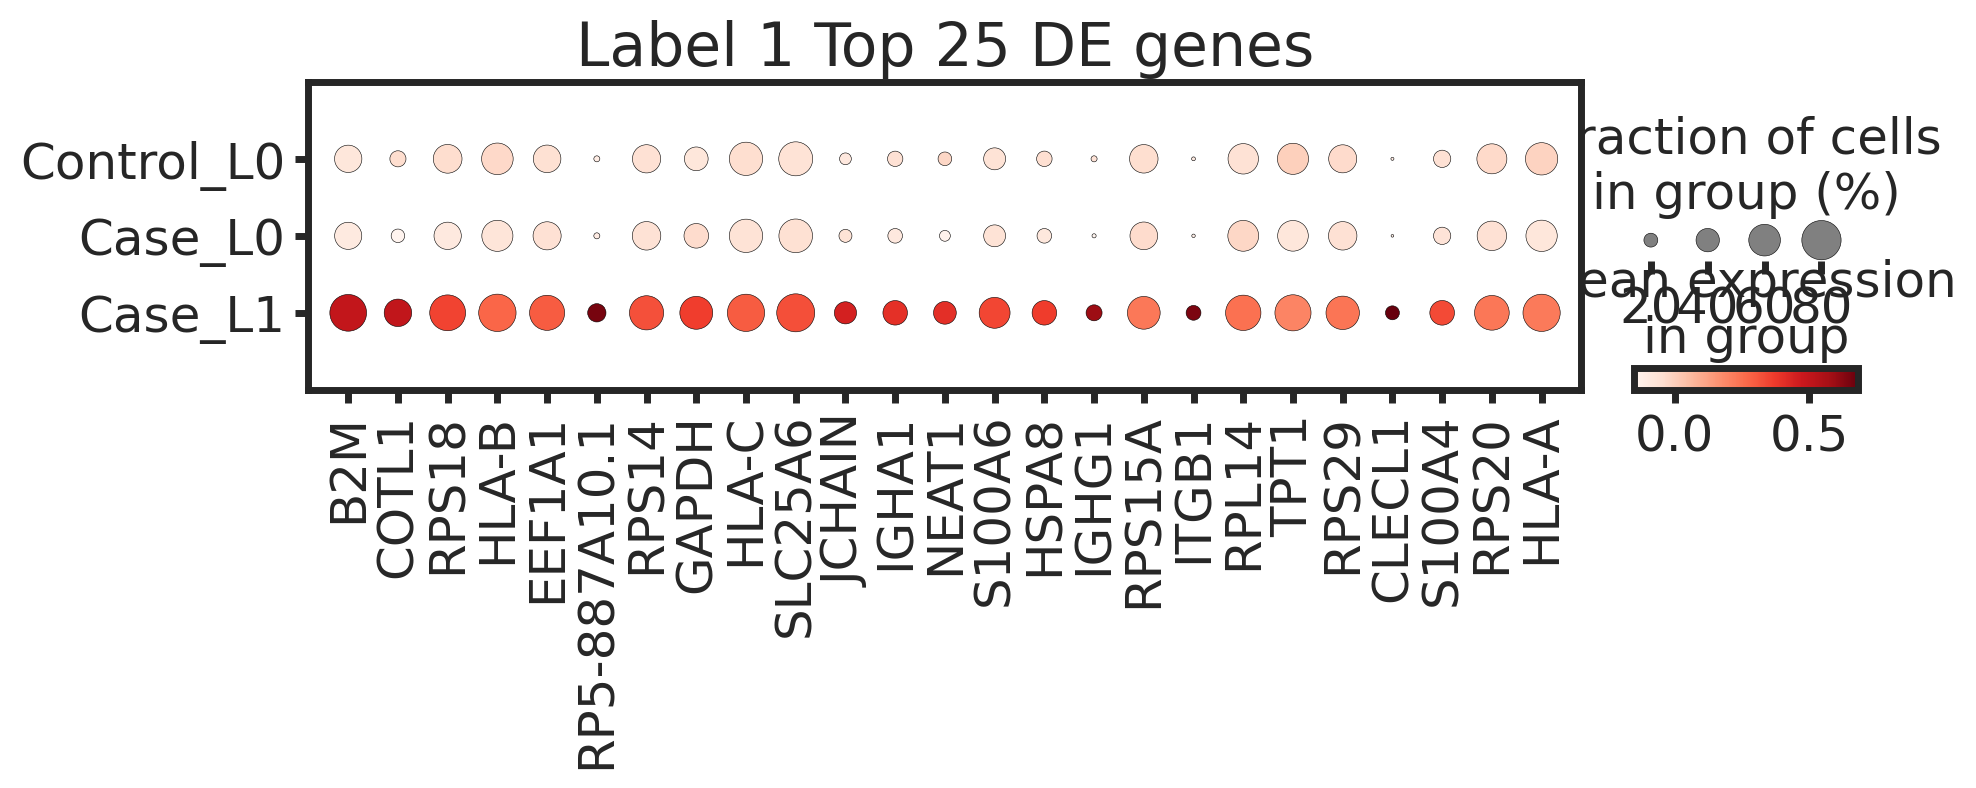

In [26]:
dp = sc.pl.dotplot(adata=adata, 
                   use_raw=False,
                   var_names= de_genes['1.0'][0:25], 
                   groupby='three_labels',
                   categories_order=['Control_L0', 'Case_L0', 'Case_L1'],
                   #standard_scale = 'var',
                   title='Label 1 Top 25 DE genes',
                   figsize=(10, 2))
#dp.add_totals().style(dot_edge_color='black', dot_edge_lw=0.5).show()
plt.show()